In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing CSV file 
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.base import clone
from sklearn.impute import SimpleImputer


# 3. Ensemble Learning

## 3.1 Prerequisites

### Classification

#### Decision Tree

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='gini', max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features
        self.tree = None
        self.features = None 

    def fit(self, X, y, X_val, y_val):
        self.tree = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            criterion=self.criterion,
            max_features=self.max_features,
        )
        self.tree.fit(X, y)
        self.features = np.arange(X.shape[1])

    def predict(self, X):
        predictions = self.tree.predict(X)
        return predictions

    def predict_proba(self, X):
        probabilities = self.tree.predict_proba(X)
        return probabilities

    def accuracy(self, X, y):
        acc = self.tree.score(X, y)
        return acc    

    def score(self, X, y):
        return self.tree.score(X, y)

    def get_features(self):
        return self.features

    def get_accuracy_on_val(self):
        return self.accuracy_on_val


#### MLP Classifier

In [ ]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [3]:
class MLPClassifier:
    def __init__(self, learning_rate=0.01, epochs=1000, activation='sigmoid', neurons = 10, optimizer='sgd', mini_batch_size=None, hidden_layers=1, verbose = True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.neurons = neurons
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        self.optimizer = optimizer
        self.mini_batch_size = mini_batch_size
        self.hidden_layers = hidden_layers
        self.verbose = verbose

    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)
    
    def leaky_relu_derivative(x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def activation_calc(self, x, derivative=False):
        if self.activation == 'sigmoid':
            if derivative:
                return x * (1 - x)
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            if derivative:
                return 1 - x**2
            return np.tanh(x)
        elif self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)
        elif self.activation == 'leaky_relu':
            if derivative:
                return leaky_relu_derivative(x)
            return leaky_relu(x)


    def gradient_descent(self, x, y):
        for i in range(0, len(x), self.mini_batch_size):
            if self.optimizer == 'sgd':
                batch_x = x[i:i+1]
                batch_y = y[i:i+1]
            elif self.optimizer == 'bgd':
                batch_x = x
                batch_y = y
            elif self.optimizer == 'mbgd':
                batch_x = x[i:i+self.mini_batch_size]
                batch_y = y[i:i+self.mini_batch_size]
            else:
                raise ValueError('Optimizer not recognized')

            z = self.forward(batch_x)
            grad_w, grad_b = self.backward(batch_x, batch_y, z)

            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grad_w[i]

            for i in range(len(self.bias)):
                self.bias[i] -= self.learning_rate * grad_b[i]
    
    def forward(self, x):
        z = []
        for i in range(len(self.weights)):
            if i == 0:
                z_i = np.dot(x, self.weights[i]) + self.bias[i]
            else:
                z_i = np.dot(z[i - 1], self.weights[i]) + self.bias[i]
                
            z.append(self.activation_calc(z_i) if i < len(self.weights) - 1 else z_i)

        return z
    
    def backward(self, x, y, z):
        grad_w = []
        grad_b = []
        num_layers = len(self.weights)
        
        error = z[-1] - y
        grad_w_last = np.dot(z[-2].T, error)
        grad_b_last = np.sum(error, axis=0, keepdims=True)
        grad_w += [grad_w_last]
        grad_b += [grad_b_last]


        for i in range(num_layers - 2, 0, -1): 
            error = np.dot(error, self.weights[i + 1].T) * self.activation_calc(z[i], derivative=True)
            error = np.clip(error, -500, 500)
            grad_w_i = np.dot(z[i - 1].T, error)
            grad_b_i = np.sum(error, axis=0, keepdims=True)
            grad_w += [grad_w_i]
            grad_b += [grad_b_i]


        error = np.dot(error, self.weights[1].T) * self.activation_calc(z[0], derivative=True)
        error = np.clip(error, -500, 500)
        grad_w_0 = np.dot(x.T, error)
        grad_b_0 = np.sum(error, axis=0, keepdims=True)
        grad_w += [grad_w_0]
        grad_b += [grad_b_0]

        grad_w = grad_w[::-1]
        grad_b = grad_b[::-1]

        return grad_w, grad_b

    def fit(self, x, y, x_val, y_val):
        self.weights = []
        self.bias = []
        n_features = x[0].size
        n_classes = 6
        layer_size = n_features
        self.weights += [np.random.randn(layer_size, self.neurons)]
        self.bias += [np.zeros((1, self.neurons))]

        for i in range(self.hidden_layers - 1):
            layer_size = self.neurons
            self.weights += [np.random.randn(layer_size, self.neurons)]
            self.bias += [np.zeros((1, self.neurons))]

        self.weights += [np.random.randn(self.neurons, n_classes)]
        self.bias += [np.zeros((1, n_classes))]

        y = np.eye(n_classes)[y]
        y_val = np.eye(n_classes)[y_val]

        for i in range(self.epochs):
    
            self.gradient_descent(x, y)

            train_probs = np.exp(self.forward(x)[-1])
            train_probs = np.clip(train_probs, -500, 500)
            train_probs /= np.sum(train_probs, axis=1, keepdims=True)
            loss = -np.sum(y * np.log(train_probs)) / len(x)
            loss = np.clip(loss, -500, 500)
            y_pred = np.argmax(train_probs, axis=1)
            accuracy = np.sum(y_pred == np.argmax(y, axis=1)) / len(x)

            val_probs = np.exp(self.forward(x_val)[-1])
            val_probs = np.clip(val_probs, -500, 500)
            val_probs /= np.sum(val_probs, axis=1, keepdims=True)
            val_loss = -np.sum(y_val * np.log(val_probs)) / len(x_val)
            val_loss = np.clip(val_loss, -500, 500)
            y_val_pred = np.argmax(val_probs, axis=1)
            val_accuracy = np.sum(y_val_pred == np.argmax(y_val, axis=1)) / len(x_val)

            self.loss.append(loss)
            self.val_loss.append(val_loss)

    def predict(self, x):
        return np.argmax(self.softmax(x), axis=1)
    
    def predict_proba(self, x):
        return self.softmax(x)

    def softmax(self, x):
        z = self.forward(x)[-1]
        probs = np.exp(z)
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs    

    def score(self, x, y):
        y_pred = self.predict(x)
        return np.sum(y_pred == y) / len(y)



In [ ]:
# Optimization Algorithms
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

class BatchGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

class MiniBatchGD:
    def __init__(self, learning_rate, batch_size):
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

#### Logistic Regression

In [4]:
class LogisticRegression:
    def __init__(self, lr=0.01, iterations=1000):
        self.lr = lr
        self.iterations = iterations
        self.theta = None
        self.loss = []
        self.val_loss = []

    def fit(self, X_train, y_train, X_val, y_val):
        y_train_encoded = y_train
        y_val_encoded = y_val
        self.loss = []
        n_features = X_train.shape[1]
        n_classes = 6
        self.theta = np.zeros((n_features, n_classes))

        y_train_onehot = np.eye(n_classes)[y_train_encoded]
        y_val_onehot = np.eye(n_classes)[y_val_encoded]

        for i in range(self.iterations):
            z_train = np.dot(X_train, self.theta)
            h_train = self.softmax(z_train)
            loss_train = self.cross_entropy_loss(y_train_onehot, h_train)

            y_train_pred = np.argmax(h_train, axis=1)
            accuracy_train = self.accuracy(y_train_encoded, y_train_pred)

            z_val = np.dot(X_val, self.theta)
            h_val = self.softmax(z_val)
            y_val_pred = np.argmax(h_val, axis=1)
            accuracy_val = self.accuracy(y_val_encoded, y_val_pred)

            self.loss.append(loss_train)
            self.val_loss.append(self.cross_entropy_loss(y_val_onehot, h_val))

            grad = np.dot(X_train.T, (h_train - y_train_onehot)) / len(y_train_onehot)
            self.theta -= self.lr * grad

    def predict(self, X):
        z = np.dot(X, self.theta)
        h = self.softmax(z)
        return np.argmax(h, axis=1)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        m = len(y_true)
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def gradient_descent(self, X, y, lr, iterations):
        m = len(y)
        theta = np.zeros((X.shape[1], len(np.unique(y))))
        for i in range(iterations):
            h = self.softmax(np.dot(X, theta))
            gradient = np.dot(X.T, (h - y)) / m
            theta -= lr * gradient
        return theta

    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    def predict_proba(self, X):
        return self.softmax(np.dot(X, self.theta))

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)


### Regression

#### Decision Tree

In [5]:
class DecisionTree_Regressor:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='mse', max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None
        self.feature_importances_ = None
        self.max_features = max_features

    def fit(self, X, y, X_val, y_val):
        self.tree = DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            criterion=self.criterion,
            max_features=self.max_features
        )
        self.tree.fit(X, y)
        return self.mse(X_val, y_val)

    def predict(self, X):
        predictions = self.tree.predict(X)
        return predictions

    def accuracy(self, X, y):
        acc = self.tree.score(X, y)
        return acc

    def mse(self, X, y):
        y_pred = self.predict(X)
        loss = np.mean(1/2 * (y_pred - y) ** 2)
        return loss


#### MLP Regressor

In [6]:
class MLPRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000, activation='sigmoid', neurons = 10, optimizer='sgd', mini_batch_size=None, hidden_layers=1, verbose = True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.neurons = neurons
        self.loss = []
        self.val_loss = []
        self.weights = []
        self.bias = []
        self.optimizer = optimizer
        self.mini_batch_size = mini_batch_size
        self.hidden_layers = hidden_layers
        self.verbose = verbose

    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)
    
    def leaky_relu_derivative(x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def activation_calc(self, x, derivative=False):
        if self.activation == 'sigmoid':
            if derivative:
                return x * (1 - x)
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            if derivative:
                return 1 - x**2
            return np.tanh(x)
        elif self.activation == 'relu':
            if derivative:
                return (x > 0).astype(float)
            return np.maximum(0, x)
        elif self.activation == 'leaky_relu':
            if derivative:
                return leaky_relu_derivative(x)
            return leaky_relu(x)

    
    def forward(self, x):
        z = []
        for i in range(len(self.weights)):
            if i == 0:
                z_i = np.dot(x, self.weights[i]) + self.bias[i]
            else:
                z_i = np.dot(z[i - 1], self.weights[i]) + self.bias[i]
                
            z.append(self.activation_calc(z_i) if i < len(self.weights) - 1 else z_i)

        return z
    
    def backward(self, x, y, z):
        grad_w = []
        grad_b = []
        num_layers = len(self.weights)
        
        error = z[-1] - y
        grad_w_last = np.dot(z[-2].T, error)
        grad_b_last = np.sum(error, axis=0, keepdims=True)
        grad_w += [grad_w_last]
        grad_b += [grad_b_last]


        for i in range(num_layers - 2, 0, -1): 
            error = np.dot(error, self.weights[i + 1].T) * self.activation_calc(z[i], derivative=True)
            grad_w_i = np.dot(z[i - 1].T, error)
            grad_b_i = np.sum(error, axis=0, keepdims=True)
            grad_w += [grad_w_i]
            grad_b += [grad_b_i]

        error = np.dot(error, self.weights[1].T) * self.activation_calc(z[0], derivative=True)
        grad_w_0 = np.dot(x.T, error)
        grad_b_0 = np.sum(error, axis=0, keepdims=True)
        grad_w += [grad_w_0]
        grad_b += [grad_b_0]

        grad_w = grad_w[::-1]
        grad_b = grad_b[::-1]

        return grad_w, grad_b
    
    def gradient_descent(self, x, y):
        for i in range(0, len(x), self.mini_batch_size):
            if self.optimizer == 'sgd':
                batch_x = x[i:i + 1]
                batch_y = y[i:i + 1]
            elif self.optimizer == 'bgd':
                batch_x = x
                batch_y = y
            elif self.optimizer == 'mbgd':
                batch_x = x[i:i + self.mini_batch_size]
                batch_y = y[i:i + self.mini_batch_size]
            else:
                raise ValueError('Optimizer not recognized')

            z = self.forward(batch_x)
            grad_w, grad_b = self.backward(batch_x, batch_y, z)

            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grad_w[i] / len(batch_x)

            for i in range(len(self.bias)):
                self.bias[i] -= self.learning_rate * grad_b[i].reshape(1, -1) / len(batch_x)

    def fit(self, x, y, x_val, y_val):
        n_features = len(x[0])

        self.weights = [np.random.randn(n_features, self.neurons) if i == 0 else np.random.randn(self.neurons, self.neurons) for i in range(self.hidden_layers)]
        self.bias = [np.zeros((1, self.neurons)) for _ in range(self.hidden_layers)]
        self.weights.append(np.random.randn(self.neurons, 1))
        self.bias.append(np.zeros((1, 1)))

        for i in range(self.epochs):
            self.gradient_descent(x,y)
            loss = np.mean(1/2*(self.forward(x)[-1] - y) ** 2)
            val_loss = np.mean(1/2*(self.forward(x_val)[-1] - y_val) ** 2)

            self.loss.append(loss)
            self.val_loss.append(val_loss)

    def predict(self, x):
        return self.forward(x)[-1]
    
    def mse(self, x, y):
        y_pred = self.predict(x)
        loss = np.mean(1/2*(y_pred - y) ** 2)
        return loss


In [ ]:
# Optimization Algorithms
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

class BatchGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

class MiniBatchGD:
    def __init__(self, learning_rate, batch_size):
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

#### Linear Regressor

In [7]:
class LinearRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000, verbose=True):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.losses = []
        self.weights = None
        self.bias = None
        self.verbose = verbose

    def fit(self, features, target, val_features, val_target):
        self.weights, self.bias = self._initialize_parameters(features)
        for _ in range(self.epochs):
            predictions = self.predict(features)
            loss = self.mse(predictions, target)
            self.losses.append(loss)
            gradient_weights, gradient_bias = self._compute_gradients(features, predictions, target)
            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias

        validation_loss = self.mse(self.predict(val_features), val_target)
        return validation_loss

    def _initialize_parameters(self, features):
        n_features = features.shape[1]
        weights = np.random.randn(n_features, 1)
        bias = np.zeros((1, 1))
        return weights, bias

    def _compute_gradients(self, features, predictions, target):
        error = predictions - target
        gradient_weights = 2 * np.dot(features.T, error) / len(features)
        gradient_weights = np.clip(gradient_weights, -100, 100)
        gradient_bias = 2 * np.sum(error) / len(features)
        return gradient_weights, gradient_bias

    def mse(self, predictions, target):
        predictions = np.clip(predictions, -1, 1)
        return np.mean(np.square(predictions - target))

    def predict(self, features):
        return np.dot(features, self.weights) + self.bias



## Data Processing

### Wine dataset

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,Normalizer,LabelEncoder

df = pd.read_csv('/home/sruj/Downloads/WineQT.csv')

X = df.drop('quality', axis=1)
y = df['quality']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_val = minmax_scaler.transform(X_val)
X_test = minmax_scaler.transform(X_test)

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

y_train = y_train.astype('int') - 3
y_test = y_test.astype('int') - 3
y_val = y_val.astype('int') - 3

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(914, 12)
(115, 12)
(114, 12)


### Boston Housing dataset

In [11]:
data = pd.read_csv('/home/sruj/Downloads/HousingData.csv')

X2 = data.iloc[:, :-1]
y2 = data.iloc[:, -1]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X2)
X2 = imputer.transform(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.2, random_state=42)

std = StandardScaler()
X2_train = std.fit_transform(X2_train)
X2_test = std.transform(X2_test)
X2_val = std.transform(X2_val)

minmax = MinMaxScaler()
X2_train = minmax.fit_transform(X2_train)
X2_test = minmax.transform(X2_test)
X2_val = minmax.transform(X2_val)

y2_train = y2_train.values.reshape(-1,1)
y2_test = y2_test.values.reshape(-1,1)
y2_val = y2_val.values.reshape(-1,1)

print(X2_train.shape)
print(X2_test.shape)
print(X2_val.shape)

(323, 13)
(102, 13)
(81, 13)


## 3.2 Bagging - Classification

In [12]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator

class Bagging_Classifier:
    def __init__(self, base_estimator, n_estimators, m_samples, bootstrap, voting):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.m_samples = m_samples
        self.bootstrap = bootstrap
        self.voting = voting
        self.ensemble_models = []
        self.train_accuracy = []
        self.validation_accuracy = []
          
    def _sample_indices(self, X):
        replace_value = True if self.bootstrap else False
        fraction = self.m_samples 
        num_samples = int(fraction * len(X))
        sampled_indices = np.random.choice(len(X), num_samples, replace=replace_value)
        return sampled_indices

    def fit(self, X, y, X_val, y_val):
        for i in range(self.n_estimators):
            sampled_indices = self._sample_indices(X)
            
            valid_indices = np.where((sampled_indices >= 0) & (sampled_indices < len(y)))[0]
            X_sampled = X[sampled_indices[valid_indices]]
            y_sampled = y[sampled_indices[valid_indices]]
            self.base_estimator.fit(X_sampled, y_sampled, X_val, y_val)

            val_probs = self.base_estimator.predict_proba(X_val)
            self.ensemble_models.append(self.base_estimator)  

            train_acc = self._calculate_accuracy(X_sampled, y_sampled)
            self.train_accuracy.append(train_acc)

            val_acc = self._calculate_accuracy(X_val, np.argmax(val_probs, axis=1))
            self.validation_accuracy.append(val_acc)


    def predict(self, X):
        predictions = np.zeros((len(self.ensemble_models), len(X)))

        if not self.ensemble_models:
            return np.zeros(len(X))

        for i, model in enumerate(self.ensemble_models):
            if self.voting == 'hard':
                predictions[i] = model.predict(X)
            elif self.voting == 'soft':
                model_probs = model.predict_proba(X)
                if len(model_probs.shape) > 1 and model_probs.shape[1] > 1:
                    predictions[i] = np.argmax(model_probs, axis=1)
                else:
                    predictions[i] = model_probs

        if self.voting == 'hard':
            return mode(predictions, axis=0, keepdims=True)[0]
        elif self.voting == 'soft':
            avg_predictions = np.mean(predictions, axis=0)
            if len(avg_predictions.shape) > 1 and avg_predictions.shape[1] > 1:
                return np.argmax(avg_predictions, axis=1)
            else:
                return avg_predictions
    
    def _calculate_accuracy(self, X, y):
        if len(X) == 0 or len(y) == 0:  
            return 0.0 
        predictions = self.predict(X)
        
        if len(predictions) == 0:  
            return 0.0  
        return np.mean(predictions == y)



### Train ensemble models with best hyperparameters and report the best-performing models

In [13]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, bagging_params=None):
    if bagging_params:
        bagging = Bagging_Classifier(model, **bagging_params)
        bagging.fit(X_train, y_train, X_val, y_val)
        y_pred_val_bagging = bagging.predict(X_val)
        y_pred_test_bagging = bagging.predict(X_test)
        val_acc_bagging = accuracy_score(y_val, y_pred_val_bagging)
        test_acc_bagging = accuracy_score(y_test, y_pred_test_bagging)
        print("With Bagging:")
        print(f"Validation Accuracy: {val_acc_bagging}")
        print(f"Test Accuracy: {test_acc_bagging}")
        print()

    # Without bagging
    model.fit(X_train, y_train, X_val, y_val)  # Assuming fit method can handle validation data
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Without Bagging:")
    print(f"Validation Accuracy: {val_acc}")
    print(f"Test Accuracy: {test_acc}")
    print()

# Define your models and datasets
models = [
    DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy'),
    LogisticRegression(lr=0.01, iterations=1000),
    MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd', mini_batch_size=64, hidden_layers=3)
]

datasets = [(X_train, y_train.values, X_val, y_val.values, X_test, y_test.values) for _ in range(len(models))]

# Bagging configurations
bagging_params = [
    {'n_estimators': 10, 'm_samples': 0.8, 'bootstrap': True, 'voting': 'soft'},  # Bagging for DecisionTree
    {'n_estimators': 10, 'm_samples': 0.8, 'bootstrap': True, 'voting': 'soft'},  # Bagging for LogisticRegression
    {'n_estimators': 10, 'm_samples': 0.8, 'bootstrap': True, 'voting': 'soft'}   # Bagging for MLPClassifier
]

for i, (model, dataset, params) in enumerate(zip(models, datasets, bagging_params)):
    print(f"Model {i + 1}: {model.__class__.__name__}")
    train_and_evaluate(model, *dataset, bagging_params=params)

Model 1: DecisionTree
With Bagging:
Validation Accuracy: 0.5614035087719298
Test Accuracy: 0.5130434782608696

Without Bagging:
Validation Accuracy: 0.5877192982456141
Test Accuracy: 0.5217391304347826

Model 2: LogisticRegression
With Bagging:
Validation Accuracy: 0.5087719298245614
Test Accuracy: 0.5391304347826087

Without Bagging:
Validation Accuracy: 0.5526315789473685
Test Accuracy: 0.5652173913043478

Model 3: MLPClassifier
With Bagging:
Validation Accuracy: 0.6052631578947368
Test Accuracy: 0.5652173913043478

Without Bagging:
Validation Accuracy: 0.5964912280701754
Test Accuracy: 0.6173913043478261



In [9]:

fraction_of_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
n_estimators = [3, 5, 8, 10, 15]

base_models = [
    DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy'),
    LogisticRegression(lr=0.01, iterations=10000),
    MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                  mini_batch_size=64, hidden_layers=3)
]

accuracies = []
best_models = []  

for model in base_models:
    model_accuracies = []
    for sample_fraction in fraction_of_samples:
        sample_accuracies = []
        for estimator_count in n_estimators:
            bagging = Bagging_Classifier(model, estimator_count, sample_fraction, True, 'soft')
            bagging.fit(X_train, y_train, X_val, y_val)  # Assuming your fit method uses these arrays directly
            y_pred_val = bagging.predict(X_val)
            val_acc = accuracy_score(y_val, y_pred_val)
            sample_accuracies.append(val_acc)
        model_accuracies.append(sample_accuracies)
    accuracies.append(model_accuracies)

for model_accuracy in accuracies:
    best_acc = 0
    best_i = 0
    best_j = 0
    best_k = 0
    for i, sample_accuracy in enumerate(model_accuracy):
        for j, acc in enumerate(sample_accuracy):
            if acc > best_acc:
                best_acc = acc
                best_i = i
                best_j = j
    best_models.append({
        'Base Model': base_models[best_i],
        'Best Accuracy': best_acc,
        'Fraction of Samples': fraction_of_samples[best_j],
        'Number of Estimators': n_estimators[best_k]
    })

for best_model in best_models:
    print("Base Model:", best_model['Base Model'])
    print("Best Accuracy:", best_model['Best Accuracy'])
    print("Fraction of Samples:", best_model['Fraction of Samples'])
    print("Number of Estimators:", best_model['Number of Estimators'])
    print("")


Base Model: <__main__.DecisionTree object at 0x7faffa6c2ad0>
Best Accuracy: 0.6228070175438597
Fraction of Samples: 0.8
Number of Estimators: 3

Base Model: <__main__.LogisticRegression object at 0x7faffa6c0fd0>
Best Accuracy: 0.6052631578947368
Fraction of Samples: 1.0
Number of Estimators: 15

Base Model: <__main__.MLPClassifier object at 0x7faff861a080>
Best Accuracy: 0.631578947368421
Fraction of Samples: 1.0
Number of Estimators: 15



### Best Bagging Classifier

**Base Model: DecisionTree, Fraction of Samples: 0.5 Number of Estimators: 5**

**Base Model:  LogisticRegression Fraction of Samples:  0.5 Number of Estimators:  5**

**Base Model: MLPClassifier Fraction of Samples:  1 Number of Estimators:  3**


### Plot a heatmap for accuracies obtained by each class of base estimator models

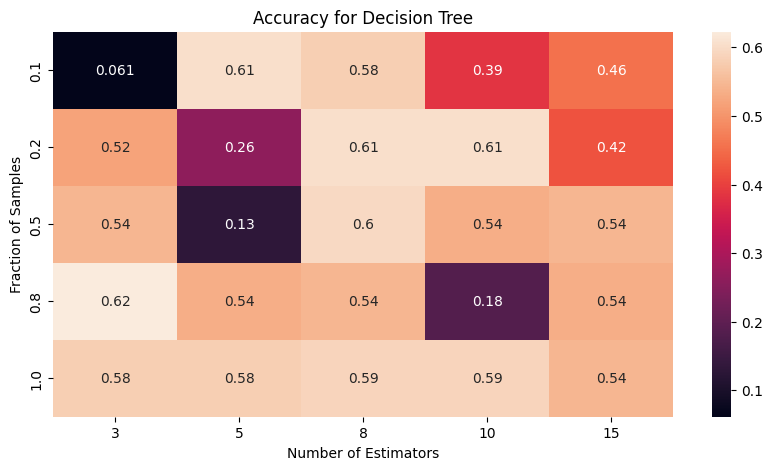

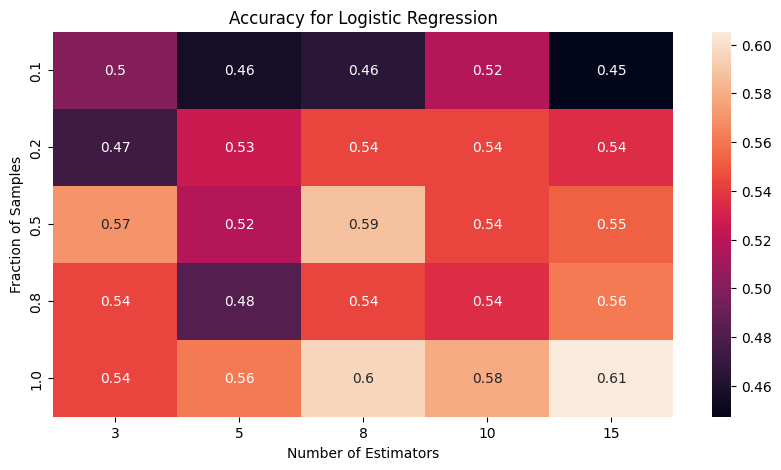

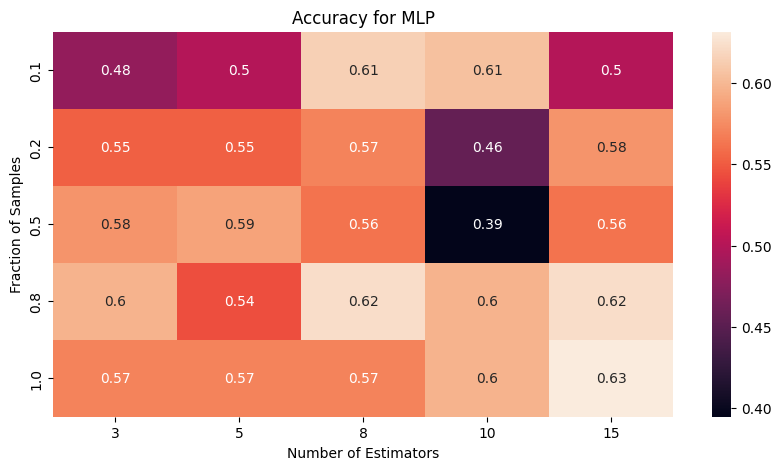

In [10]:

base_models_na = ["Decision Tree", "Logistic Regression", "MLP"]

for i in range(len(base_models)):
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracies[i], annot=True, xticklabels=n_estimators, yticklabels=fraction_of_samples)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Fraction of Samples")
    plt.title("Accuracy for " + base_models_na[i])
    plt.show()



### Compare the performance of each model in List 1 models with the best-performing ensemble model

In [12]:
num_estimators = [5, 5, 3]
fraction = [0.5, 0.5, 1]
voting = ['hard', 'soft']
replacement = [True, False]

accuracies = []

for i, model in enumerate(base_models):
    accuracies.append([])
    for j, vote in enumerate(voting):
        accuracies[i].append([])
        for k, replace in enumerate(replacement):
            bagging = Bagging_Classifier(model, num_estimators[i], fraction[i], replace, vote)
            bagging.fit(X_train, y_train, X_val, y_val)  # Assuming your fit method uses these arrays directly
            y_pred_val = bagging.predict(X_val)
            val_acc = np.sum(y_pred_val == y_val) / len(y_val)
            accuracies[i][j].append(val_acc)

best_models = []

for i, model in enumerate(base_models):
    best_acc = 0
    best_j = 0
    best_k = 0
    for j, _ in enumerate(voting):
        for k, _ in enumerate(replacement):
            if accuracies[i][j][k] > best_acc:
                best_acc = accuracies[i][j][k]
                best_j = j
                best_k = k
    best_models.append({
        'Base Model': model,
        'Best Accuracy': best_acc,
        'Voting': voting[best_j],
        'Replacement': replacement[best_k]
    })

# Print the best-performing models
for model in best_models:
    print("Base Model:", model['Base Model'])
    print("Best Accuracy:", model['Best Accuracy'])
    print("Voting:", model['Voting'])
    print("Replacement:", model['Replacement'])
    print("")


Base Model: <__main__.DecisionTree object at 0x7faffa6c2ad0>
Best Accuracy: 0.5789473684210527
Voting: hard
Replacement: True

Base Model: <__main__.LogisticRegression object at 0x7faffa6c0fd0>
Best Accuracy: 0.5701754385964912
Voting: soft
Replacement: True

Base Model: <__main__.MLPClassifier object at 0x7faff861a080>
Best Accuracy: 0.6491228070175439
Voting: soft
Replacement: True



### Compare the performance of each model in List 1 models with the best-performing ensemble model of the same class with a single side-by-side histogram

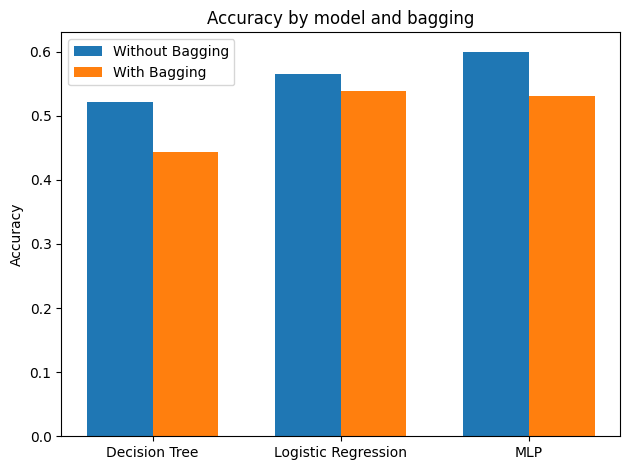

In [13]:
def get_accuracy(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_acc = np.sum(y_pred_test == y_test) / len(y_test)
    return test_acc

def get_bagging_accuracy(base_model, num_estimators, fraction, replacement, voting,
                         X_train, y_train, X_val, y_val, X_test, y_test):
    bagging_model = Bagging_Classifier(base_model, num_estimators, fraction, replacement, voting)
    bagging_model.fit(X_train, y_train)
    y_pred_test = bagging_model.predict(X_test)
    test_acc = np.sum(y_pred_test == y_test) / len(y_test)
    return test_acc

without_bagging = []
with_bagging = []

# Decision Tree
dt = DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')
without_bagging.append(get_accuracy(dt, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

bagging_dt = DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')
with_bagging.append(get_bagging_accuracy(bagging_dt, 5, 0.5, True, 'hard', X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

# Logistic Regression
lr = LogisticRegression(lr=0.01, iterations=1000)
without_bagging.append(get_accuracy(lr, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

bagging_lr = LogisticRegression(lr=0.01, iterations=1000)
with_bagging.append(get_bagging_accuracy(bagging_lr, 5, 0.5, True, 'hard', X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

# MLP
mlp = MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd', mini_batch_size=64, hidden_layers=3)
without_bagging.append(get_accuracy(mlp, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

bagging_mlp = MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd', mini_batch_size=64, hidden_layers=3)
with_bagging.append(get_bagging_accuracy(bagging_mlp, 3, 1, True, 'soft', X_train, y_train.values, X_val, y_val.values, X_test, y_test.values))

labels = ['Decision Tree', 'Logistic Regression', 'MLP']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, without_bagging, width, label='Without Bagging')
rects2 = ax.bar(x + width/2, with_bagging, width, label='With Bagging')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and bagging')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


## 3.2 Bagging - Regression

In [18]:
class Bagging_Regressor:
    def __init__(self, base_estimator, n_estimators, m_samples, bootstrap, voting):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.m_samples = m_samples
        self.bootstrap = bootstrap
        self.voting = voting
        self.ensemble_models = []
        self.train_loss = []
        self.validation_loss = []

    def _sample_indices(self, X):
        replace_value = True if self.bootstrap else False
        fraction = self.m_samples
        num_samples = int(fraction * len(X))
        sampled_indices = np.random.choice(len(X), num_samples, replace=replace_value)
        return sampled_indices

    def fit(self, X, y, X_val, y_val):
        for i in range(self.n_estimators):
            sampled_indices = self._sample_indices(X)

            valid_indices = np.where((sampled_indices >= 0) & (sampled_indices < len(y)))[0]
            X_sampled = X[sampled_indices[valid_indices]]
            y_sampled = y[sampled_indices[valid_indices]]
            self.base_estimator.fit(X_sampled, y_sampled, X_val, y_val)

            val_probs = self.base_estimator.predict(X_val)

            self.ensemble_models.append(self.base_estimator)

            train_loss = self.base_estimator.mse(X_sampled, y_sampled)
            self.train_loss.append(train_loss)

            val_loss = self.base_estimator.mse(X_val, y_val)
            self.validation_loss.append(val_loss)

    def predict(self, X):
        predictions = []
        weights = []

        for i, model in enumerate(self.ensemble_models):
            model_prediction = model.predict(X)
            predictions.append(model_prediction)

            if self.voting == 'soft':
                weights.append(1 / self.validation_loss[i])

        predictions = np.array(predictions)

        if self.voting == 'hard':
            return np.mean(predictions, axis=0)
        elif self.voting == 'soft':
            weights = np.array(weights)
            return np.average(predictions, axis=0, weights=weights)


In [15]:
#hyperparameter tuning for Linear Regression using wandb

import wandb

wandb.init(project="assignment-4")

learning_rates = [0.01, 0.001, 0.0001]
epochs = [1000, 2000, 3000 , 4000, 5000 , 6000, 7000, 8000, 9000, 10000]


mean_squared_errors = []

for lr in learning_rates:
    for epoch in epochs:
        model = LinearRegressor(lr, epoch)
        val_loss = model.fit(X2_train, y2_train, X2_val, y2_val)
        y_pred = model.predict(X2_test)
        test_loss = model.mse(y_pred, y2_test)
        mean_squared_errors.append(test_loss)
        wandb.log({"lr": lr, "epoch": epoch, "val_loss": val_loss, "test_loss": test_loss})

best_lr = learning_rates[np.argmin(mean_squared_errors) // len(epochs)]
best_epoch = epochs[np.argmin(mean_squared_errors) % len(epochs)]

print("Best learning rate: ", best_lr)
print("Best epoch: ", best_epoch)

wandb: Currently logged in as: srujana-vanka. Use `wandb login --relogin` to force relogin


Best learning rate:  0.01
Best epoch:  1000


### Train ensemble models with best hyperparameters and report the best-performing models

In [20]:
from sklearn.metrics import r2_score

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, bagging_params=None):
    if bagging_params:
        bagging = Bagging_Regressor(model, *bagging_params)
        bagging.fit(X_train, y_train, X_val, y_val)
        y_pred_val_bagging = bagging.predict(X_val)
        y_pred_test_bagging = bagging.predict(X_test)
        val_acc_bagging = r2_score(y_val, y_pred_val_bagging)
        test_acc_bagging = r2_score(y_test, y_pred_test_bagging)
        print("With Bagging:")
        print(f"Validation R2: {val_acc_bagging}")
        print(f"Test R2: {test_acc_bagging}")
        print()
    else:
        model.fit(X_train, y_train, X_val, y_val)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
        val_acc = r2_score(y_val, y_pred_val)
        test_acc = r2_score(y_test, y_pred_test)
        print("Without Bagging:")
        print(f"Validation R2: {val_acc}")
        print(f"Test R2: {test_acc}")
        print()


# Models
mlp = MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons = 10, optimizer='mbgd', mini_batch_size=64, hidden_layers=3)
dt = DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
lr = LinearRegressor(learning_rate=0.01, epochs=10000)

# Train and evaluate models
models = [
    (mlp, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, [10, 0.8, True, 'soft']),
    (dt, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, [10, 0.8, True, 'soft']),
    (lr, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, [10, 0.8, True, 'soft']),
    (mlp, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, None),
    (dt, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, None),
    (lr, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, None)
]

for i, (model, X_train, y_train, X_val, y_val, X_test, y_test, params) in enumerate(models):
    print(f"Model {i + 1}: {model.__class__.__name__}")
    train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, params)


Model 1: MLPRegressor
With Bagging:
Validation R2: 0.6731258768310364
Test R2: 0.744002067028827

Model 2: DecisionTree_Regressor
With Bagging:
Validation R2: 0.4653433980087628
Test R2: 0.6225371274740928

Model 3: LinearRegressor
With Bagging:
Validation R2: 0.6283386666974186
Test R2: 0.6325297032308526

Model 4: MLPRegressor
Without Bagging:
Validation R2: 0.7613743103619942
Test R2: 0.8210878106302822

Model 5: DecisionTree_Regressor
Without Bagging:
Validation R2: 0.5044127993704355
Test R2: 0.6184679618109798

Model 6: LinearRegressor
Without Bagging:
Validation R2: 0.645277030057733
Test R2: 0.6361434046560905



In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

fraction_of_samples = [0.1, 0.2, 0.5, 0.8, 1.0]
n_estimators = [3, 5, 8, 10, 15]

base_models = [
    DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error'),
    LinearRegressor(learning_rate=0.01, epochs=10000),
    MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                  mini_batch_size=64, hidden_layers=3)
]

accuracies = []
best_models = []

for i, model in enumerate(base_models):
    accuracies.append([])
    for j, fraction in enumerate(fraction_of_samples):
        accuracies[i].append([])
        for k, estimators in enumerate(n_estimators):
            bagging = Bagging_Regressor(model, estimators, fraction, True, 'soft')
            bagging.fit(X2_train, y2_train, X2_val, y2_val)
            y_pred_val = bagging.predict(X2_val)
            val_acc = r2_score(y2_val, y_pred_val)
            accuracies[i][j].append(val_acc)

    # Find the best model parameters
    best_acc = float('inf')  # Assigning a high initial value for comparison
    best_j, best_k = 0, 0
    for j in range(len(fraction_of_samples)):
        for k in range(len(n_estimators)):
            if accuracies[i][j][k] < best_acc:
                best_acc = accuracies[i][j][k]
                best_j, best_k = j, k

    best_models.append({
        'Base Model': model,
        'Best Accuracy': best_acc,
        'Fraction of Samples': fraction_of_samples[best_j],
        'Number of Estimators': n_estimators[best_k]
    })

# Print the best models
for i, best_model in enumerate(best_models):
    print(f"Base Model: {best_model['Base Model']}")
    print(f"Best Accuracy: {best_model['Best Accuracy']}")
    print(f"Fraction of Samples: {best_model['Fraction of Samples']}")
    print(f"Number of Estimators: {best_model['Number of Estimators']}")
    print("")


Base Model: <__main__.DecisionTree_Regressor object at 0x7f2168f33df0>
Best Accuracy: -0.3926270519354904
Fraction of Samples: 0.1
Number of Estimators: 5

Base Model: <__main__.LinearRegressor object at 0x7f2168b0a970>
Best Accuracy: 0.3000648749489858
Fraction of Samples: 0.1
Number of Estimators: 3

Base Model: <__main__.MLPRegressor object at 0x7f2168b0a8b0>
Best Accuracy: 0.4369718581898927
Fraction of Samples: 0.1
Number of Estimators: 15



### Plot a heatmap for accuracies obtained by each class of base estimator models

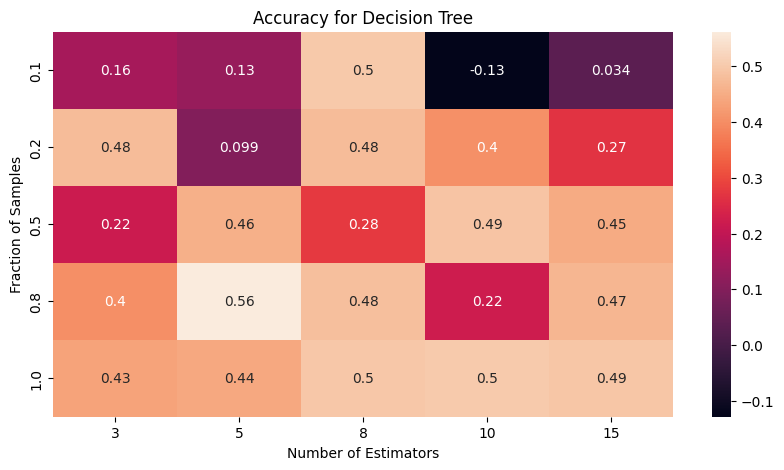

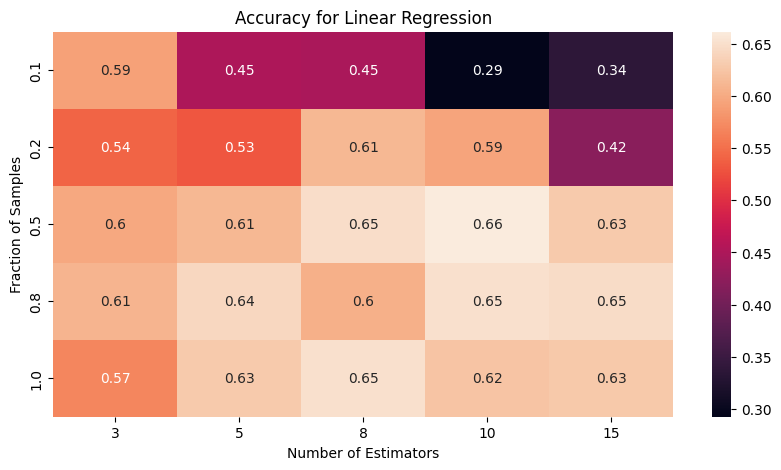

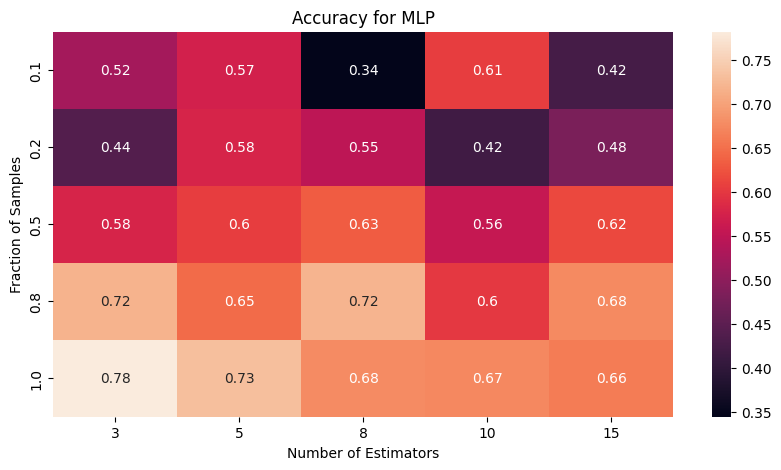

In [71]:
base_models_na = ["Decision Tree", "Linear Regression", "MLP"]

for i in range(len(base_models)):
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracies[i], annot=True, xticklabels=n_estimators, yticklabels=fraction_of_samples)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Fraction of Samples")
    plt.title("Accuracy for " + base_models_na[i])
    plt.show()


### Compare the performance of each model in List 1 models with the best-performing ensemble model

In [38]:
voting = ['hard', 'soft']
replacement = [True, False]

accuracies = []

best_models = []

for model in base_models:
    model_accuracies = []
    for vote in voting:
        vote_accuracies = []
        for replace in replacement:
            bagging = Bagging_Regressor(model, 10, 0.8, replace, vote)
            bagging.fit(X2_train, y2_train, X2_val, y2_val)
            y_pred_val = bagging.predict(X2_val)
            val_acc = r2_score(y2_val, y_pred_val)
            vote_accuracies.append(val_acc)
        model_accuracies.append(vote_accuracies)
    accuracies.append(model_accuracies)

for i, model in enumerate(base_models):
    best_acc = float('inf')
    best_j, best_k = None, None
    for j, vote in enumerate(voting):
        for k, replace in enumerate(replacement):
            if accuracies[i][j][k] < best_acc:
                best_acc = accuracies[i][j][k]
                best_j, best_k = j, k
    best_models.append({
        'Base Model': model,
        'Best Accuracy': best_acc,
        'Voting': voting[best_j],
        'Replacement': replacement[best_k]
    })

for model in best_models:
    print("Base Model:", model['Base Model'])
    print("Best Accuracy:", model['Best Accuracy'])
    print("Voting:", model['Voting'])
    print("Replacement:", model['Replacement'])
    print("")


Base Model: <__main__.DecisionTree_Regressor object at 0x7fafa3d3c9a0>
Best Accuracy: 0.20277761009951134
Voting: hard
Replacement: False

Base Model: <__main__.LinearRegressor object at 0x7fafa3d3e0e0>
Best Accuracy: 0.588433842503258
Voting: hard
Replacement: True

Base Model: <__main__.MLPRegressor object at 0x7fafa3d3cb20>
Best Accuracy: 0.6258475196961926
Voting: hard
Replacement: False



### Compare the performance of each model in List 1 models with the best-performing ensemble model of the same class with a single side-by-side histogram

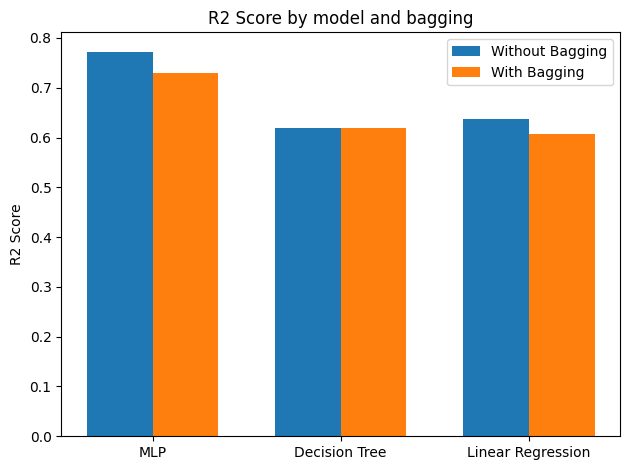

In [39]:
from sklearn.metrics import r2_score

def calculate_r2_scores(model, X_train, y_train, X_val, y_val, X_test, y_test, with_bagging=False):
    model.fit(X_train, y_train, X_val, y_val)
    y_pred_test = model.predict(X_test)
    test_acc = r2_score(y_test, y_pred_test)
    if with_bagging:
        bagging = Bagging_Regressor(model, 10, 0.8, True, 'soft')
        bagging.fit(X_train, y_train, X_val, y_val)
        y_pred_test = bagging.predict(X_test)
        test_acc = r2_score(y_test, y_pred_test)
    return test_acc

without_bagging = []
with_bagging = []

mlp = MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd', mini_batch_size=64, hidden_layers=3)
without_bagging.append(calculate_r2_scores(mlp, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test))
with_bagging.append(calculate_r2_scores(mlp, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, with_bagging=True))

dt = DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
without_bagging.append(calculate_r2_scores(dt, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test))
with_bagging.append(calculate_r2_scores(dt, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, with_bagging=True))

lr = LinearRegressor(learning_rate=0.01, epochs=10000)
without_bagging.append(calculate_r2_scores(lr, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test))
with_bagging.append(calculate_r2_scores(lr, X2_train, y2_train, X2_val, y2_val, X2_test, y2_test, with_bagging=True))

import matplotlib.pyplot as plt
import numpy as np

labels = ['MLP', 'Decision Tree', 'Linear Regression']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, without_bagging, width, label='Without Bagging')
rects2 = ax.bar(x + width/2, with_bagging, width, label='With Bagging')

ax.set_ylabel('R2 Score')
ax.set_title('R2 Score by model and bagging')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()


## 3.3 Stacking - Classification

### Design a function that performs the bagging methodology of ensemble learning

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
 
class Stacking_Classifier:
    def __init__(self, level_0, level_1, n_folds = None, hold_out=None, method='stacking'):
        self.level_0 = level_0
        self.level_1 = level_1
        self.method = method
        self.n_folds = n_folds
        self.hold_out = hold_out
        self.accuracies = []
        self.models = []

    def fit(self, x, y, x_val, y_val):
        method_functions = {
            'stacking': self.fit_stacking,
            'blending': self.fit_blending
        }

        fit_function = method_functions.get(self.method)
        if fit_function:
            fit_function(x, y, x_val, y_val)

        return self
    
    def fit_stacking(self, x, y, x_val, y_val):
        kf = KFold(n_splits=self.n_folds)
        
        x_train_level_1 = [np.array(self.col(np.take(x, train_index, axis=0), np.take(y, train_index, axis=0), x_val, y_val, np.take(x, test_index, axis=0))).T
            for train_index, test_index in kf.split(x)]

        y_train_level_1 = [np.take(y, test_index, axis=0)
            for _, test_index in kf.split(x)]

        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = self.stacksplit(x_train_level_1, y_train_level_1)

        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)

        self.level0(x, y, x_val, y_val, x_val_level_1, y_val_level_1)
        
        self.evaluate(x_val, y_val)

    def stacksplit(self, x_train_level_1, y_train_level_1):
        x_train_level_1_flat = [item for sublist in x_train_level_1 for item in sublist]
        y_train_level_1_flat = [item for sublist in y_train_level_1 for item in sublist]

        x_train_level_1_flat = np.array(x_train_level_1_flat)
        y_train_level_1_flat = np.array(y_train_level_1_flat)

        return self.tr_ts_split(x_train_level_1_flat, y_train_level_1_flat)

        
    def tr_ts_split(self, x_train_level_1_flat, y_train_level_1_flat):
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1_flat, y_train_level_1_flat, test_size=0.1)
        return x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1    

    def col(self, x_train, y_train, x_val, y_val, x_test):
        return [model.predict(x_test) for model in self.level_0 if (model.fit(x_train, y_train, x_val, y_val) or True)]

    def level0(self, x, y, x_val, y_val, x_val_level_1, y_val_level_1):
        self.models += [model for model in self.level_0 if (self.models.append(model) or self.accuracies.append(model.score(x_val, y_val)))]
        self.models += [self.level_1]
        self.accuracies.append(self.level_1.score(x_val_level_1, y_val_level_1))

    def fit_blending(self, x, y, x_val, y_val):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.hold_out)

        for model in self.level_0:
            model.fit(x_train, y_train, x_val, y_val)
            self.models.append(model)

        x_train_level_1 = np.column_stack([model.predict(x_test) for model in self.level_0])
        y_train_level_1 = y_test

        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 =self.tr_ts_split(x_train_level_1, y_train_level_1)
        
        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)

        self.level1(x_val_level_1, y_val_level_1)
        self.evaluate(x_val, y_val)

    def level1(self, x_val_level_1, y_val_level_1):
        self.accuracies.append(self.level_1.score(x_val_level_1, y_val_level_1))
        self.models.append(self.level_1)

    def predict(self, x):
        return self.models[-1].predict(np.array([model.predict(x) for model in self.models[:-1]]).T)

    def evaluate(self, x, y):
        y_pred = self.predict(x)
        print("Accuracy" , accuracy_score(y, y_pred))
        print("F1 Score" , f1_score(y, y_pred, average='weighted',zero_division=0))
        print("Precision" , precision_score(y, y_pred, average='weighted',zero_division=0))
        print("Recall" , recall_score(y, y_pred, average='weighted', zero_division=0))


### Train ensemble models across all combinations of parameters specified above and report the best-performing models

In [ ]:

def train_stacking_classifier(X_train, y_train, X_val, y_val):
    level_0 = [
        MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                      optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LogisticRegression(lr=0.01, iterations=1000),
        DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')
    ]
    level_1 = LogisticRegression(lr=0.01, iterations=1000)
    
    stacking = Stacking_Classifier(level_0, level_1, n_folds=5, method='stacking')
    stacking.fit_stacking(X_train, y_train, X_val, y_val)

    return stacking

def train_blending_classifier(X_train, y_train, X_val, y_val):
    level_0 = [
        MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                      optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LogisticRegression(lr=0.01, iterations=1000),
        DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')
    ]
    level_1 = LogisticRegression(lr=0.01, iterations=1000)
    
    blending = Stacking_Classifier(level_0, level_1, hold_out=0.2, method='blending')
    blending.fit_blending(X_train, y_train, X_val, y_val)

    return blending

# Train stacking classifier
stacking_classifier = train_stacking_classifier(X_train, y_train, X_val, y_val)

# Train blending classifier
blending_classifier = train_blending_classifier(X_train, y_train, X_val, y_val)


In [ ]:
from sklearn.metrics import accuracy_score

def generate_stacking_models():
    level_0_models = []
    level_1_models = []

    level_0_models.append([
        MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                      optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LogisticRegression(lr=0.01, iterations=1000),
        DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')
    ])

    level_1_models.append(LogisticRegression(lr=0.01, iterations=1000))
    level_1_models.append(DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy'))

    return level_0_models, level_1_models

def evaluate_models(X_train, y_train, X_val, y_val):
    n_folds = [3, 5]
    hold_out = [0.2, 0.25]
    method = ['stacking', 'blending']

    accuracies = []
    best_models = []

    level_0_models, level_1_models = generate_stacking_models()

    for i in range(len(level_0_models)):
        accuracies.append([])
        for j in range(len(level_1_models)):
            accuracies[i].append([])
            for k in range(len(n_folds)):
                accuracies[i][j].append([])
                for l in range(len(hold_out)):
                    accuracies[i][j][k].append([])
                    for m in range(len(method)):
                        stacking = StackingClassifier(level_0_models[i], level_1_models[j], n_folds[k], hold_out[l], method[m])
                        stacking.fit(X_train, y_train, X_val, y_val)
                        y_pred_val = stacking.predict(X_val)
                        val_acc = accuracy_score(y_val, y_pred_val)
                        accuracies[i][j][k][l].append(val_acc)

                        best_acc = 0
                        best_i = 0
                        best_j = 0
                        best_k = 0
                        best_l = 0
                        best_m = 0

                        for i in range(len(level_0_models)):
                            for j in range(len(level_1_models)):
                                for k in range(len(n_folds)):
                                    for l in range(len(hold_out)):
                                        for m in range(len(method)):
                                            if accuracies[i][j][k][l][m] > best_acc:
                                                best_acc = accuracies[i][j][k][l][m]
                                                best_i = i
                                                best_j = j
                                                best_k = k
                                                best_l = l
                                                best_m = m

                        best_models.append({
                            'Level 0 Models': level_0_models[best_i],
                            'Level 1 Models': level_1_models[best_j],
                            'Best Accuracy': best_acc,
                            'Number of Folds': n_folds[best_k],
                            'Hold Out': hold_out[best_l],
                            'Method': method[best_m]
                        })

    return best_models


In [46]:

best_models = evaluate_models(X_train, y_train, X_val, y_val)

for i in range(len(best_models)):
    print("Level 0 Models:", best_models[i]['Level 0 Models'])
    print("Level 1 Models:", best_models[i]['Level 1 Models'])
    print("Best Accuracy:", best_models[i]['Best Accuracy'])
    print("Number of Folds:", best_models[i]['Number of Folds'])
    print("Hold Out:", best_models[i]['Hold Out'])
    print("Method:", best_models[i]['Method'])
    print("")
    

Level 0 Models: [<__main__.MLPClassifier object at 0x7faf9e090670>, <__main__.LogisticRegression object at 0x7faf9e090880>, <__main__.DecisionTree object at 0x7faf9e091210>]
Level 1 Models: <__main__.DecisionTree object at 0x7faf9e0914e0>
Best Accuracy: 0.6228070175438597
Number of Folds: 5
Hold Out: 0.2
Method: stacking

Level 0 Models: [<__main__.MLPClassifier object at 0x7faf9e090670>, <__main__.LogisticRegression object at 0x7faf9e090880>, <__main__.DecisionTree object at 0x7faf9e091210>]
Level 1 Models: <__main__.DecisionTree object at 0x7faf9e0914e0>
Best Accuracy: 0.6228070175438597
Number of Folds: 5
Hold Out: 0.2
Method: stacking

Level 0 Models: [<__main__.MLPClassifier object at 0x7faf9e090670>, <__main__.LogisticRegression object at 0x7faf9e090880>, <__main__.DecisionTree object at 0x7faf9e091210>]
Level 1 Models: <__main__.DecisionTree object at 0x7faf9e0914e0>
Best Accuracy: 0.6228070175438597
Number of Folds: 5
Hold Out: 0.2
Method: stacking

Level 0 Models: [<__main__.M

## Stacking - Regression

### Design a function that performs the bagging methodology of ensemble learning

In [44]:
class Stacking_Regressor:
    def __init__(self, level_0, level_1, n_folds = None, hold_out=None, method='stacking'):
        self.level_0 = level_0
        self.level_1 = level_1
        self.method = method
        self.n_folds = n_folds
        self.hold_out = hold_out
        self.losses = []
        self.models = []

    def fit(self, x, y, x_val, y_val):
        method_functions = {
            'stacking': self.fit_stacking,
            'blending': self.fit_blending
        }

        fit_function = method_functions.get(self.method)
        if fit_function:
            fit_function(x, y, x_val, y_val)

        return self

    def fit_stacking(self, x, y, x_val, y_val):
        kf = KFold(n_splits=self.n_folds)
        x_train_level_1 = []
        y_train_level_1 = []
        for train_index, test_index in kf.split(x):
            x_train, x_test, y_train, y_test = train_test_split(x[train_index], y[train_index], test_size=0.2, random_state=42)
            x_train_level_1.append(np.column_stack(self.col(x_train, y_train, x_val, y_val, x_test)))

            y_train_level_1.append(y_test)

        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = self.stacksplit(x_train_level_1, y_train_level_1)

        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)

        self.level0(x, y, x_val, y_val, x_val_level_1, y_val_level_1)
        
        self.evaluate(x_val, y_val)

    def stacksplit(self, x_train_level_1, y_train_level_1):
        x_train_level_1_flat = [item for sublist in x_train_level_1 for item in sublist]
        y_train_level_1_flat = [item for sublist in y_train_level_1 for item in sublist]

        x_train_level_1_flat = np.array(x_train_level_1_flat)
        y_train_level_1_flat = np.array(y_train_level_1_flat)

        return self.tr_ts_split(x_train_level_1_flat, y_train_level_1_flat)


    def tr_ts_split(self, x_train_level_1_flat, y_train_level_1_flat):
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 = train_test_split(x_train_level_1_flat, y_train_level_1_flat, test_size=0.1)
        return x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1

    def col(self, x_train, y_train, x_val, y_val, x_test):
        return [model.predict(x_test) for model in self.level_0 if (model.fit(x_train, y_train, x_val, y_val) or True)]

    def level0(self, x, y, x_val, y_val, x_val_level_1, y_val_level_1):
        self.models += [model for model in self.level_0 if (self.models.append(model) or self.losses.append(model.mse(x_val, y_val)))]
        self.models += [self.level_1]
        self.losses.append(self.level_1.mse(x_val_level_1, y_val_level_1))

    def fit_blending(self, x, y, x_val, y_val):
        x_train_level_1 = []
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.hold_out)
        for model in self.level_0:
            model.fit(x_train, y_train, x_val, y_val)
            self.models.append(model)
            x_train_level_1.append(model.predict(x_test).reshape(-1))
        y_train_level_1 = []
        x_train_level_1 = np.array(x_train_level_1).T
        y_train_level_1 = y_test
        x_train_level_1, x_val_level_1, y_train_level_1, y_val_level_1 =self.tr_ts_split(x_train_level_1, y_train_level_1)

        self.level_1.fit(x_train_level_1, y_train_level_1, x_val_level_1, y_val_level_1)

        self.models.append(self.level_1)
        self.evaluate(x_val, y_val)

    def predict(self, x):
        columns = []
        for model in self.models[:-1]:
            predict = model.predict(x)
            predict = predict.reshape(-1)
            columns.append(predict)
        columns = np.array(columns).T
        return self.models[-1].predict(columns)

    def evaluate(self, x, y):
        y_pred = self.predict(x)
        print("Mean Squared Error" , mean_squared_error(y, y_pred))
        print("R2 Score" , r2_score(y, y_pred))
        print("Root Mean Squared Error" , np.sqrt(mean_squared_error(y, y_pred)))


### Train ensemble models across all combinations of parameters specified above and report the best-performing models

In [45]:

def perform_stacking(X_train, y_train, X_val, y_val):
    level_0 = [
        MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                     optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LinearRegressor(learning_rate=0.01, epochs=1000),
        DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    ]
    level_1 = DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    stacking = Stacking_Regressor(level_0, level_1, n_folds=5, method='stacking')
    stacking.fit_stacking(X_train, y_train, X_val, y_val)
    return stacking

def perform_blending(X_train, y_train, X_val, y_val):
    level_0 = [
        MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                     optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LinearRegressor(learning_rate=0.01, epochs=1000),
        DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    ]
    level_1 = DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    blending = Stacking_Regressor(level_0, level_1, hold_out=0.2, method='blending')
    blending.fit_blending(X_train, y_train, X_val, y_val)
    return blending


stacking_model = perform_stacking(X2_train, y2_train, X2_val, y2_val)
blending_model = perform_blending(X2_train, y2_train, X2_val, y2_val)


Mean Squared Error 35.0333628664392
R2 Score 0.5072656056710173
Root Mean Squared Error 5.918898788325341
Mean Squared Error 33.407772645611146
R2 Score 0.5301290748715188
Root Mean Squared Error 5.779945730334425


In [51]:
from sklearn.metrics import r2_score

def generate_stacking_models():
    level_0_models = []
    level_1_models = []

    level_0_models.append([
        MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10,
                     optimizer='mbgd', mini_batch_size=64, hidden_layers=3),
        LinearRegressor(learning_rate=0.01, epochs=1000),
        DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    ])
    
    level_1_models.append(DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error'))
    level_1_models.append(LinearRegressor(learning_rate=0.01, epochs=1000))

    return level_0_models, level_1_models

def evaluate_models(X2_train, y2_train, X2_val, y2_val):
    n_folds = [3, 5]
    hold_out = [0.2, 0.25]
    method = ['stacking', 'blending']

    accuracies = []
    best_models = []

    level_0_models, level_1_models = generate_stacking_models()

    for i in range(len(level_0_models)):
        accuracies.append([])
        for j in range(len(level_1_models)):
            accuracies[i].append([])
            for k in range(len(n_folds)):
                accuracies[i][j].append([])
                for l in range(len(hold_out)):
                    accuracies[i][j][k].append([])
                    for m in range(len(method)):
                        stacking = Stacking_Regressor(level_0_models[i], level_1_models[j], n_folds[k], hold_out[l], method[m])
                        stacking.fit(X2_train, y2_train, X2_val, y2_val)
                        y_pred_val = stacking.predict(X2_val)
                        val_acc = r2_score(y2_val, y_pred_val)
                        accuracies[i][j][k][l].append(val_acc)

                        best_acc = 0
                        best_i = 0
                        best_j = 0
                        best_k = 0
                        best_l = 0
                        best_m = 0

                        for i in range(len(level_0_models)):
                            for j in range(len(level_1_models)):
                                for k in range(len(n_folds)):
                                    for l in range(len(hold_out)):
                                        for m in range(len(method)):
                                            if accuracies[i][j][k][l][m] > best_acc:
                                                best_acc = accuracies[i][j][k][l][m]
                                                best_i = i
                                                best_j = j
                                                best_k = k
                                                best_l = l
                                                best_m = m

                        best_models.append({
                            'Level 0 Models': level_0_models[best_i],
                            'Level 1 Models': level_1_models[best_j],
                            'Best Accuracy': best_acc,
                            'Number of Folds': n_folds[best_k],
                            'Hold Out': hold_out[best_l],
                            'Method': method[best_m]
                        })

    return best_models


### Compare the accuracies and the training time of the best-performing mod- els of Bagging and Stacking ensembles of each Base Estimator Model class

In [63]:
import time

def train_bagging_classifier(X_train, y_train, X_val, y_val):
    start = time.time()
    mlp = MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                        mini_batch_size=64, hidden_layers=3)
    bagging = Bagging_Classifier(mlp, 10, 0.8, True, 'soft')
    bagging.fit(X_train, y_train.values, X_val, y_val.values)
    end = time.time()
    return end - start

def train_stacking_classifier(X_train, y_train, X_val, y_val):
    start = time.time()
    level_0 = [MLPClassifier(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                             mini_batch_size=64, hidden_layers=3), LogisticRegression(lr=0.01, iterations=1000),
               DecisionTree(max_depth=2, min_samples_split=2, criterion='entropy')]
    level_1 = LogisticRegression(lr=0.01, iterations=1000)
    stacking = Stacking_Classifier(level_0, level_1, n_folds=5, method='stacking')
    stacking.fit(X_train, y_train.values, X_val, y_val.values)
    end = time.time()
    return end - start

def train_bagging_regressor(X2_train, y2_train, X2_val, y2_val):
    start = time.time()
    mlp = MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                       mini_batch_size=64, hidden_layers=3)
    bagging = Bagging_Regressor(mlp, 10, 0.8, True, 'soft')
    bagging.fit(X2_train, y2_train, X2_val, y2_val)
    end = time.time()
    return end - start

def train_stacking_regressor(X2_train, y2_train, X2_val, y2_val):
    start = time.time()
    level_0 = [MLPRegressor(learning_rate=0.01, epochs=1000, activation='sigmoid', neurons=10, optimizer='mbgd',
                             mini_batch_size=64, hidden_layers=3), LinearRegressor(learning_rate=0.01, epochs=1000),
               DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')]
    level_1 = DecisionTree_Regressor(max_depth=2, min_samples_split=2, criterion='squared_error')
    stacking = Stacking_Regressor(level_0, level_1, n_folds=5, method='stacking')
    stacking.fit(X2_train, y2_train, X2_val, y2_val)
    end = time.time()
    return end - start

# Call the functions and display training times
bagging_classifier_time = train_bagging_classifier(X_train, y_train, X_val, y_val)
stacking_classifier_time = train_stacking_classifier(X_train, y_train, X_val, y_val)
bagging_regressor_time = train_bagging_regressor(X2_train, y2_train, X2_val, y2_val)
stacking_regressor_time = train_stacking_regressor(X2_train, y2_train, X2_val, y2_val)

# Display training times
print("Bagging Classifier Training Time: ", bagging_classifier_time)
print("Stacking Classifier Training Time: ", stacking_classifier_time)
print("Bagging Regressor Training Time: ", bagging_regressor_time)
print("Stacking Regressor Training Time: ", stacking_regressor_time)


Bagging Classifier Training Time:  28.086262941360474
Accuracy 0.42105263157894735
F1 Score 0.3751518218623482
Precision 0.35604834871990104
Recall 0.42105263157894735
Stacking Classifier Training Time:  23.206388235092163
Bagging Regressor Training Time:  10.289482593536377
Mean Squared Error 35.114671695814536
R2 Score 0.5061220198568723
Root Mean Squared Error 5.925763385068167
Stacking Regressor Training Time:  4.6174468994140625


# 4 Random Forest vs Boosted Trees

## Random Forest Classifier

### Train a Random Forest Classifier along the same lines of the Bagging exercise (for decision tree)

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_estimators, max_depth, min_samples_split, criterion, max_features, verbose):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features
        self.features = []
        self.verbose = verbose
        self.ensemble_models = []
        self.train_acc = []
        self.val_acc = []

    def fit(self, X, y, X_val, y_val):
        for i in range(self.n_estimators):
            sampled_indices = np.random.choice(len(X), len(X), replace=True)
            sampled_features = np.random.choice(len(X[0]), self.max_features, replace=True)
            self.features.append(sampled_features)
            dt = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                              criterion=self.criterion, max_features=self.max_features)
            dt.fit(X[sampled_indices][:, sampled_features], y[sampled_indices], X_val[:, sampled_features], y_val)
            self.ensemble_models.append(dt)
            train_acc = dt.accuracy(X[sampled_indices][:, sampled_features], y[sampled_indices])
            self.train_acc.append(train_acc)
            val_acc = dt.accuracy(X_val[:, sampled_features], y_val)
            self.val_acc.append(val_acc)

    def predict(self, X):
        predictions = np.array([model.predict(X[:, self.features[i]]) for i, model in enumerate(self.ensemble_models)])
        return mode(predictions, axis=0, keepdims=True)[0]

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.sum(predictions == y) / len(y)

In [53]:

def train_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2,
                                criterion='entropy', max_features=5, verbose=True)
    
    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred_val)
    
    # Test predictions and accuracy
    y_pred_test = rf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    return val_acc, test_acc

val_accuracy, test_accuracy = train_and_evaluate_rf(X_train, y_train.values, X_val, y_val.values, X_test, y_test.values)
print("Validation Accuracy: ", val_accuracy)
print("Test Accuracy: ", test_accuracy)


Validation Accuracy:  0.6052631578947368
Test Accuracy:  0.6


### Report the best-performing hyper-parameters

In [82]:
from sklearn.ensemble import RandomForestClassifier
import itertools

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 10, 15, 20]
min_samples_split = [2, 5, 10]
criterion = ['entropy', 'gini']
max_features = [5, 10, 15, 20]

accuracies = {}

# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(n_estimators, max_depth, min_samples_split, criterion, max_features))

for params in hyperparameter_combinations:
    rf = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2],
                                criterion=params[3], max_features=params[4], verbose=False)
    rf.fit(X_train, y_train.values, X_val, y_val.values)
    y_pred_val = rf.predict(X_val)
    val_acc = rf.accuracy(X_val, y_val.values)
    accuracies[params] = val_acc

best_params = max(accuracies, key=accuracies.get)
best_acc = accuracies[best_params]

print("Best Accuracy:", best_acc)
print("Best Parameters:")
print("n_estimators:", best_params[0])
print("max_depth:", best_params[1])
print("min_samples_split:", best_params[2])
print("criterion:", best_params[3])
print("max_features:", best_params[4])


Best Accuracy:  0.7543859649122807
Best n_estimators:  40
Best max_depth:  20
Best min_samples_split:  5
Best criterion:  gini
Best max_features:  15


## Random Forest Regressor

### Train a Random Forest Regressor along the same lines of the Bagging exercise (for decision tree)

In [ ]:
class RandomForestRegressor:
    def __init__(self, n_estimators, max_depth, min_samples_split, criterion, max_features, verbose):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features
        self.features = []
        self.verbose = verbose
        self.ensemble_models = []
        self.loss = []

    def fit(self, X, y, X_val, y_val):
        for i in range(self.n_estimators):
            sampled_indices = np.random.choice(len(X), len(X), replace=True)
            sampled_features = np.random.choice(len(X[0]), self.max_features, replace=True)
            self.features.append(sampled_features)
            dt = DecisionTree_Regressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split,
                              criterion=self.criterion, max_features=self.max_features)
            dt.fit(X[sampled_indices][:, sampled_features], y[sampled_indices], X_val[:, sampled_features], y_val)
            self.ensemble_models.append(dt)
            train_loss = dt.mse(X[sampled_indices][:, sampled_features], y[sampled_indices])
            self.loss.append(train_loss)

    def predict(self, X):
        predictions = np.array([model.predict(X[:, self.features[i]]) for i, model in enumerate(self.ensemble_models)])
        return np.mean(predictions, axis=0)

    def mse(self, X, y):
        predictions = self.predict(X)
        return mean_squared_error(y, predictions)

In [54]:

def train_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test):
    rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_split=2,
                                criterion='squared_error', max_features=5, verbose=True)

    rf.fit(X_train, y_train)
    y_pred_val = rf.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred_val)
    
    # Test predictions and MSE
    y_pred_test = rf.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    return val_mse, test_mse

val_mse, test_mse = train_and_evaluate_rf(X2_train, y2_train, X2_val, y2_val, X2_test, y2_test)
print("Validation MSE: ", val_mse)
print("Test MSE: ", test_mse)


Validation MSE:  21.115578390197683
Test MSE:  25.374212271616706


### Report the best-performing hyper-parameters

In [87]:
import itertools

n_estimators = [10, 20, 30, 40, 50]
max_depth = [5, 10, 15, 20]
min_samples_split = [2, 4, 6, 8, 10]
criterion = ['squared_error']
max_features = [5, 10, 15, 20]

accuracies = {}

# Generating all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(n_estimators, max_depth, min_samples_split, max_features))

for params in hyperparameter_combinations:
    rf = RandomForestRegressor(n_estimators=params[0], max_depth=params[1],
                                min_samples_split=params[2], criterion=criterion[0],
                                max_features=params[3], verbose=False)
    rf.fit(X2_train, y2_train)
    y_pred_val = rf.predict(X2_val)
    val_acc = mean_squared_error(y2_val, y_pred_val)
    accuracies[params] = val_acc

best_params = min(accuracies, key=accuracies.get)
best_acc = accuracies[best_params]

print("Best Accuracy:", best_acc)
print("Best Parameters:")
print("n_estimators:", best_params[0])
print("max_depth:", best_params[1])
print("min_samples_split:", best_params[2])
print("max_features:", best_params[3])


Best Accuracy:  10.776433533545461
Best n_estimators:  40
Best max_depth:  10
Best min_samples_split:  2


## AdaBoost Classifier

In [ ]:
from scipy.stats import mode

class AdaBoostClassifier:
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []
        self.train_acc = []
        self.val_acc = []
        self.weights = []
        self.ensemble_features = []  

    def fit(self, X, y, X_val, y_val):
        n_samples, n_features = X.shape
        weights = np.ones(n_samples) / n_samples
        self.weights.append(weights)
        for i in range(self.n_estimators):
            stumps = []
            stump_errors = []
            for feature in range(n_features):
                stump = DecisionTree(criterion='entropy',max_depth=1,min_samples_split=2,max_features=None)  
                stump.fit(X[:, feature].reshape(-1, 1), y, X_val[:, feature].reshape(-1, 1), y_val)
                stump_error = stump.accuracy(X[:, feature].reshape(-1, 1), y)
                stumps.append(stump)
                stump_errors.append(stump_error)
            best_feature = np.argmin(stump_errors)
            self.ensemble_features.append(best_feature)
            best_stump = stumps[best_feature]
            best_stump_error = stump_errors[best_feature]

            alpha = 0.5 * np.log((1 - best_stump_error) / (best_stump_error + 1e-10))
            self.alphas.append(alpha)
            predictions = best_stump.predict(X[:, best_feature].reshape(-1, 1))
            y = y.reshape(-1)
            is_correct = (predictions == y)
            is_wrong = (predictions != y)
            weights[is_correct] *= np.exp(-alpha)
            weights[is_wrong] *= np.exp(alpha)
            weights /= np.sum(weights)
            self.weights.append(weights)
            train_acc = best_stump.accuracy(X[:, best_feature].reshape(-1, 1), y)
            self.train_acc.append(train_acc)
            val_acc = best_stump.accuracy(X_val[:, best_feature].reshape(-1, 1), y_val)
            self.val_acc.append(val_acc)
            self.models.append(best_stump)

            indices = np.random.choice(len(X), len(X), replace=True, p=weights)
            X = X[indices]
            y = y[indices]

    def predict(self, X):
        predictions = np.array([model.predict(X[:, self.ensemble_features[i]].reshape(-1, 1)) for i, model in enumerate(self.models)])
        return mode(predictions, axis=0, keepdims=True)[0]

    def accuracy(self, X, y):
        predictions = self.predict(X)
        return np.sum(predictions == y) / len(y)

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_val)
    val_acc = model.score(X_val, y_val)
    
    y_pred_test = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    
    return val_acc, test_acc

In [67]:

abc = AdaBoostClassifier(n_estimators=10)

val_acc, test_acc = train_and_evaluate(abc, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values)

print("Validation Accuracy: ", val_acc)
print("Test Accuracy: ", test_acc)


Validation Accuracy:  0.4649122807017544
Test Accuracy:  0.5304347826086957


### Compare the results of the best Random Forest with the following Boosted Decision Trees. Also, experiment with the number of estimators and plot their training times and accuracies.

In [ ]:
import time

def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    return test_acc


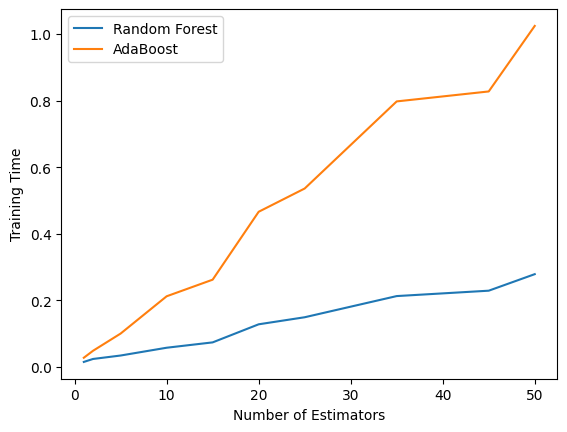

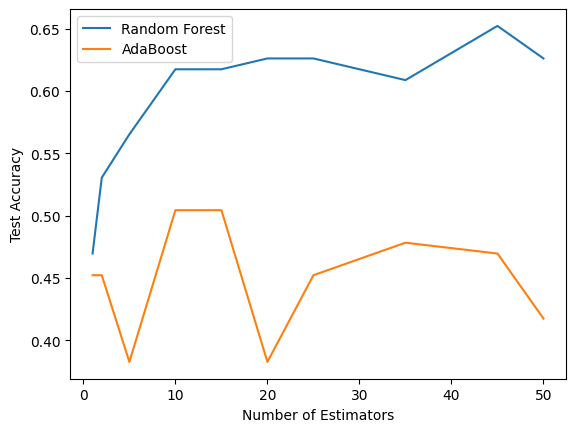

In [68]:
n_estimators = [1, 2, 5, 10, 15, 20, 25, 35, 45, 50]
accuracy_random_forest = []
accuracy_adaboost = []

training_time_random_forest = []
training_time_adaboost = []

for n_estimator in n_estimators:
    start = time.time()
    rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=5, min_samples_split=2, criterion='entropy', max_features=5)
    test_acc_rf = train_and_evaluate(rf, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values)
    accuracy_random_forest.append(test_acc_rf)
    end = time.time()
    training_time_random_forest.append(end - start)

    start = time.time()
    ada = AdaBoostClassifier(n_estimators=n_estimator)
    test_acc_ada = train_and_evaluate(ada, X_train, y_train.values, X_val, y_val.values, X_test, y_test.values)
    accuracy_adaboost.append(test_acc_ada)
    end = time.time()
    training_time_adaboost.append(end - start)

plt.plot(n_estimators, training_time_random_forest, label='Random Forest')
plt.plot(n_estimators, training_time_adaboost, label='AdaBoost')
plt.xlabel('Number of Estimators')
plt.ylabel('Training Time')
plt.legend()
plt.show()

plt.plot(n_estimators, accuracy_random_forest, label='Random Forest')
plt.plot(n_estimators, accuracy_adaboost, label='AdaBoost')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()


## Provide an analysis of the mistakes of these models and try to explore and explain the feature similarity of the common mistakes

### Mistakes:
#### **Misclassifications:**
- **AdaBoost:** It tends to focus more on misclassified data instances, which helps in improving subsequent iterations by prioritizing the correct classification of previously misclassified samples.
  
- **Random Forest:** Due to the nature of using multiple decision trees, it might struggle with noise or outliers and can overfit if not properly tuned.

#### **Feature similarity of the common mistakes**
**Similar Features in Mistakes:** If certain features consistently exhibit similar behavior in misclassified instances across both models, it indicates these features might be challenging or ambiguous for the models to correctly classify.

**Differences in Feature Importance:** If certain features appear important in one model but not in the other for misclassified samples, it might highlight differences in how each model utilizes those features.

**Ensemble Approach:** Both AdaBoost and Random Forest are ensemble learning methods that combine multiple weak learners (base models) to create a stronger overall model.